

# AI Resume RAG & Interview Coach

## Building a RAG System for Auto-Tailored Resumes and Interview Question Generation

*An end-to-end generative AI project that embeds my resume and project experiences into a vector database, retrieves the most relevant background given any job description, and automatically generates a tailored resume and interview preparation guide.*


In [1]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [2]:
# imports for langchain, plotly and Chroma
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import plotly.graph_objects as go
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.embeddings import HuggingFaceEmbeddings

In [3]:
MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [4]:
# Load environment variables in a file called .env 
dotenv_path = os.path.join(os.path.dirname(os.getcwd()), "llm_engineering", ".env") # Specify the full path to .env
load_dotenv(dotenv_path=dotenv_path, override=True)

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [5]:
# Read in documents using LangChain's loaders
# Take everything in all the sub-folders of our knowledgebase

folders = glob.glob("knowledge-base/*")

def add_metadata(doc, doc_type):
    doc.metadata["doc_type"] = doc_type
    return doc

# With thanks to CG and Jon R, students on the course, for this fix needed for some users 
text_loader_kwargs = {'encoding': 'utf-8'}
# If that doesn't work, some Windows users might need to uncomment the next line instead
# text_loader_kwargs={'autodetect_encoding': True}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    documents.extend([add_metadata(doc, doc_type) for doc in folder_docs])

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

print(f"Total number of chunks: {len(chunks)}")
print(f"Document types found: {set(doc.metadata['doc_type'] for doc in documents)}")

Created a chunk of size 1225, which is longer than the specified 1000


Total number of chunks: 34
Document types found: {'Essay', 'Technical_Skills', 'RESUME'}


In [6]:
embeddings = OpenAIEmbeddings()

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

# Create vectorstore by using Chroma

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 34 documents


In [7]:
# Let's investigate the vectors

collection = vectorstore._collection
count = collection.count()

sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")

There are 34 vectors with 1,536 dimensions in the vector store


## Visualizing the Vector Store

Let's take a minute to look at the documents and their embedding vectors to see what's going on.

In [8]:
# Prework (with thanks to Jon R for identifying and fixing a bug in this!)

result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']
doc_types = [metadata['doc_type'] for metadata in metadatas]
colors = [['blue', 'green', 'red', 'orange'][['Essay', 'Projects', 'RESUME', 'Technical_Skills'].index(t)] for t in doc_types]

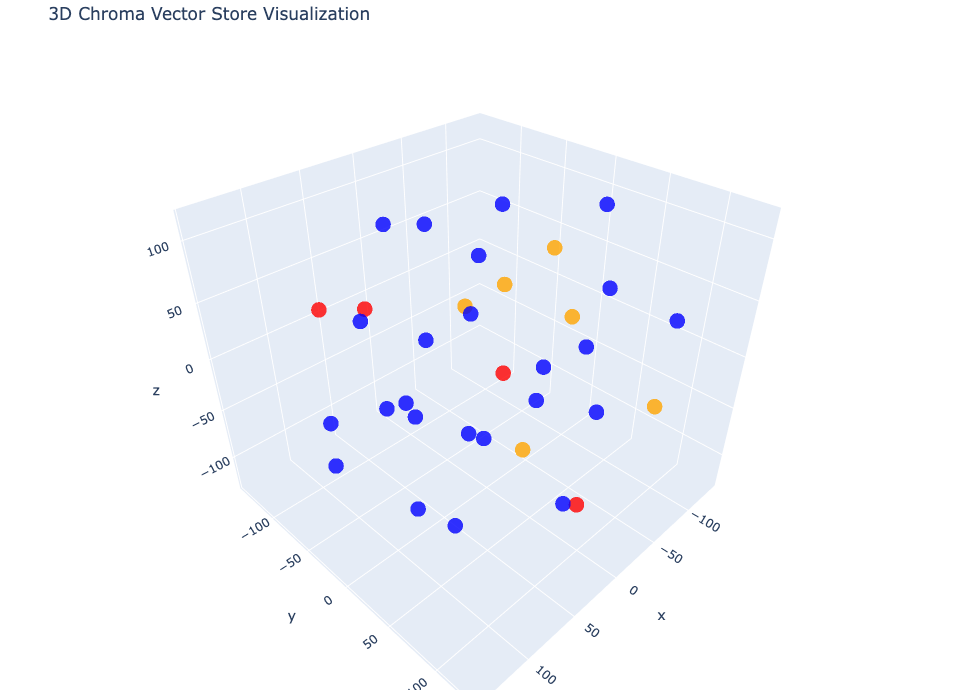

In [9]:
# Let's try 3D!

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

## Time to use LangChain to bring it all together

In [22]:
# create a new Chat with OpenAI
llm = ChatOpenAI(temperature=0.5, model_name=MODEL)

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG
retriever = vectorstore.as_retriever(search_kwargs={"k": 8})

# putting it together: set up the conversation chain with the GPT 3.5 LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

## Now we will bring this up in Gradio using the Chat interface -

A quick and easy way to prototype a chat with an LLM

In [45]:

common_system = """You are Beau's AI Career Copilot.
Use ONLY retrieved context to answer. If info is missing, write 'MISSING CONTEXT'.
Be concise, factual, and quantify achievements when possible."""

resume_prompt = ChatPromptTemplate.from_messages([
    ("system", common_system + """
Task: Given a Job Description (JD) and retrieved context, write a tailored resume section.

Output in Markdown with EXACT sections:
## Tailored Resume Summary (2–3 sentences)
- Align to JD's core skills; include concrete tools/keywords.

## Tailored Experience Bullets (4–6 bullets)
- Each bullet = Action + Context + Impact (+ metric).
- Start with strong verbs; 1–2 lines per bullet.

## Skills Match
- List JD key skills → mark "Matched" / "Gap" and reference the relevant bullets by number.
"""),
    ("human",
     """# Job Description (JD)
{question}

# Retrieved Context
{context}""")
])

interview_prompt = ChatPromptTemplate.from_messages([
    ("system", common_system + """
Task: Generate interview materials from JD + retrieved context.

Output in Markdown with EXACT sections:
## Technical Questions (6)
- Focus on the JD stack and my actual experience from the retrieved context.

## Behavioral Questions (4)
- Provide STAR hints referencing my projects.

## Suggested Talking Points
- 5–8 bullet points that tie the JD to my quantifiable achievements.
"""),
    ("human",
     """# Job Description (JD)
{question}

# Retrieved Context
{context}""")
])

In [47]:
# create a new Chat with OpenAI
llm = ChatOpenAI(temperature=0.5, model_name=MODEL)

# set up the conversation memory for the chat
memory = ConversationBufferMemory(
    memory_key="chat_history",   
    return_messages=True,        
    input_key="question",        
    output_key="answer",       
)

# the retriever is an abstraction over the VectorStore that will be used during RAG
retriever = vectorstore.as_retriever(search_kwargs={"k": 8})

# putting it together: set up the conversation chain with the GPT 3.5 LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)


resume_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    return_source_documents=False,
    combine_docs_chain_kwargs={"prompt": resume_prompt},
)

interview_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    return_source_documents=False,
    combine_docs_chain_kwargs={"prompt": interview_prompt},
)


In [49]:
import gradio as gr

SHOW_SOURCES = False

def format_sources(docs):
    if not docs:
        return ""
    lines = []
    for i, d in enumerate(docs, 1):
        src = d.metadata.get("source") or d.metadata.get("file_path") or d.metadata.get("doc_type") or "N/A"
        lines.append(f"[source:{i}] {src}")
    return "\n\n## Sources\n" + "\n".join(lines)
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import gradio as gr

# 1) 串流 LLM（注意：要與你非串流的 llm 分開）
llm_stream = ChatOpenAI(temperature=0.3, model_name=MODEL, streaming=True)

# 2) 把檢索到的文件連成文字
def join_docs(docs):
    return "\n\n".join(d.page_content for d in docs)

# 3) 串流生成器：每次 yield 目前累積的文本
def run_rag_stream(jd_text: str, mode: str):
    try:
        if not jd_text or not jd_text.strip():
            yield "**請先貼上 JD 內容**。"
            return

        # 3.1 先做檢索，組成 context
        docs = retriever.get_relevant_documents(jd_text)
        context = join_docs(docs)

        # 3.2 根據模式選擇對應 Prompt
        prompt = resume_prompt if mode == "Generate Resume Bullets" else interview_prompt

        # 3.3 用 Prompt 組出「訊息列表」
        messages = prompt.format_messages(question=jd_text, context=context)

        # 3.4 串流 LLM：逐塊回來就累加、yield
        partial = ""
        for chunk in llm_stream.stream(messages):  # chunk 是 AIMessageChunk
            partial += chunk.content or ""
            yield partial

    except Exception as e:
        import traceback
        yield f"**ERROR**: {e}\n\n```\n{traceback.format_exc()}\n```"

# 4) Gradio 介面（用 Blocks；按鈕觸發的函式回傳 generator 就會串流）
with gr.Blocks(title="AI Resume RAG & Interview Coach") as demo:
    gr.Markdown("## AI Resume RAG & Interview Coach\n貼上 JD，選擇模式，系統會從你的向量庫檢索內容後產生結果。")

    with gr.Row():
        mode = gr.Radio(
            choices=["Generate Resume Bullets", "Interview Questions"],
            value="Generate Resume Bullets",
            label="Mode"
        )

    jd = gr.Textbox(lines=15, label="Paste Job Description (JD) here")
    out = gr.Markdown(label="Output")

    btn = gr.Button("Generate")
    btn.click(fn=run_rag_stream, inputs=[jd, mode], outputs=out)

demo.queue().launch(inbrowser=True, show_error=True)



* Running on local URL:  http://127.0.0.1:7874
* To create a public link, set `share=True` in `launch()`.


/var/folders/df/7l7z2xk564z_5j9f1nvl17040000gn/T/ipykernel_70012/86437199.py:32: LangChainDeprecationWarning:

The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.

